In [1]:
import os
import logging
import time
import psycopg2

import pandas as pd
import numpy as np 
from sqlalchemy import create_engine

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
 

def connect_postgres():
    database = os.environ['POSTGRES_DB']
    user = os.environ['POSTGRES_USER']
    password = os.environ['POSTGRES_PASSWORD']
    host = os.environ['POSTGRES_SERVER']
    port = 5432

    exc, conn, engine = None, None, None

    for _ in range(5):
        try:
            conn = psycopg2.connect(
                database=database, user=user, password=password, host=host, port=port)
        except Exception as e:
            logging.warning("Error connecting to postgres, will retry in 3 sec: %s", e)
            time.sleep(3)
            exc = e
        else:
            logging.info("Connected...")
            logging.info("Everything goes well from Postgres, you're a fu*** pro...")
            
            engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
                user, password, host, port, database
            ))
            break
    else:
        logging.error("Unable to connect to  %s DB", database)
        raise exc
    
    return [conn, engine]


In [2]:
[conn, engine] = connect_postgres()

INFO:root:Connected...
INFO:root:Everything goes well from Postgres, you're a fu*** pro...


In [16]:
df_iss = pd.read_sql("""
SELECT
	copytransaction.id, title_name, code, trans_copy_code_id, trans_tittle_code_id, trans_date_id as date_iss
FROM
	public.copytransaction, public.transactiontype, public.copy, public.student, public.date, public.title
WHERE
    sede = 0 AND
    jornada = 'DIU' AND
    program = '3743' AND
	trans_type_code IN ('ISS') AND
    trans_tittle_code_id = title.id AND
	trans_date_id = date.id AND
	trans_copy_code_id = copy.id AND
	trans_borrower_code = student.id AND
	trans_type_id = transactiontype.id

ORDER BY code, trans_copy_code_id, trans_date_id, trans_type_code, id, title_name

""", con=conn)

In [17]:
df_ret = pd.read_sql("""
SELECT
    trans_copy_code_id, trans_tittle_code_id, title_name, code, trans_date_id as date_ret
FROM
	public.copytransaction, public.transactiontype, public.copy, public.student, public.date, public.title
WHERE
    sede = 0 AND
    jornada = 'DIU' AND
    program = '3743' AND
	trans_type_code IN ('RET') AND
    trans_tittle_code_id = title.id AND
	trans_date_id = date.id AND
	trans_copy_code_id = copy.id AND
	trans_borrower_code = student.id AND
	trans_type_id = transactiontype.id

ORDER BY code, trans_copy_code_id, trans_date_id, trans_type_code, copy.id, title_name

""", con=conn)

/opt/app/.venv/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [18]:
df_iss = df_iss.reset_index(drop=True)
df_iss

,id,title_name,code,trans_copy_code_id,trans_tittle_code_id,date_iss
0,39355,Competitive strategy,199120033,16331,10188,19990303
1,293269,Biología general,199120033,131785,99376,19990525
2,220902,Colombia: Analisis al futuro,199120033,184745,138918,19971112
3,187137,Investigación de operaciones en la ciencia adm...,199120033,185454,139509,19971009
4,581499,Investigación de operaciones en la ciencia adm...,199120033,185457,139509,19970820
...,...,...,...,...,...,...
44908,8802899,Precálculo,201830743,706973,705983,20180207
44909,8938708,The purge,201830957,916536,928536,20180207
44910,8764935,Game of thrones,201830990,804796,823917,20180224
44911,8919499,The imitation game [videograbación],201830990,873790,889459,20180220


In [19]:
df_ret = df_ret.reset_index(drop=True)
df_ret

,trans_copy_code_id,trans_tittle_code_id,title_name,code,date_ret
0,16331,10188,Competitive strategy,199120033,19990318
1,131785,99376,Biología general,199120033,19990526
2,184745,138918,Colombia: Analisis al futuro,199120033,19971114
3,185454,139509,Investigación de operaciones en la ciencia adm...,199120033,19971023
4,185457,139509,Investigación de operaciones en la ciencia adm...,199120033,19970919
...,...,...,...,...,...
45085,706973,705983,Precálculo,201830743,20180209
45086,916536,928536,The purge,201830957,20180207
45087,804796,823917,Game of thrones,201830990,20180224
45088,873790,889459,The imitation game [videograbación],201830990,20180220


In [20]:
df_iss = df_iss.astype({col: 'int32' for col in df_iss.select_dtypes('int64').columns})
df_iss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44913 entries, 0 to 44912
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    44913 non-null  int32 
 1   title_name            44913 non-null  object
 2   code                  44913 non-null  int32 
 3   trans_copy_code_id    44913 non-null  int32 
 4   trans_tittle_code_id  44913 non-null  int32 
 5   date_iss              44913 non-null  int32 
dtypes: int32(5), object(1)
memory usage: 1.2+ MB


In [21]:
df_ret = df_ret.astype({col: 'int32' for col in df_ret.select_dtypes('int64').columns})
df_ret.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45090 entries, 0 to 45089
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   trans_copy_code_id    45090 non-null  int32 
 1   trans_tittle_code_id  45090 non-null  int32 
 2   title_name            45090 non-null  object
 3   code                  45090 non-null  int32 
 4   date_ret              45090 non-null  int32 
dtypes: int32(4), object(1)
memory usage: 1.0+ MB


In [23]:
df = df_iss.merge(df_ret, how='left', on=['code','trans_copy_code_id', 'trans_tittle_code_id', 'title_name'])
df['diff'] = df['date_ret'] - df['date_iss']
df = df[df['diff'] >= 0]
df = df.sort_values(
    ['trans_tittle_code_id', 'diff']
)

df

,id,title_name,code,trans_copy_code_id,trans_tittle_code_id,date_iss,date_ret,diff
1239,5865695,Bases de datos e implementacion mediante DMS II,199218080,130217,24,19970424,19970424.0,0.0
10121,15054,Bases de datos e implementacion mediante DMS II,199428238,26,24,19990217,19990217.0,0.0
8889,518380,Bases de datos e implementacion mediante DMS II,199344105,130217,24,19970611,19970627.0,16.0
8403,5970129,Introduccion a la teoria general de los sistemas,199342359,30,25,20011116,20011116.0,0.0
31921,1895233,Introduccion a la teoria general de los sistemas,200333579,30,25,20040818,20040827.0,9.0
...,...,...,...,...,...,...,...,...
77806,8956782,El aliento de los dioses,201367667,911101,926149,20171108,20171207.0,99.0
89004,9117074,The purge,201827246,916536,928536,20180207,20180207.0,0.0
89015,8938708,The purge,201830957,916536,928536,20180207,20180207.0,0.0
83267,8895215,Satanás,201523548,912916,928592,20180126,20180219.0,93.0


In [24]:
df.columns

Index(['id', 'title_name', 'code', 'trans_copy_code_id',
       'trans_tittle_code_id', 'date_iss', 'date_ret', 'diff'],
      dtype='object')

In [25]:
df['ISS'] = pd.to_datetime(df['date_iss'].astype(str), format='%Y%m%d') 
df['RET'] = pd.to_datetime(df['date_ret'].astype(str), format='%Y%m%d')
df['trans_copy_code_id'] = df['trans_copy_code_id'].astype(str)
df['trans_tittle_code_id'] = df['trans_tittle_code_id'].astype(str)
df['duration'] = df['RET'] - df['ISS'] + pd.Timedelta(days=1)
df['duration'] = df['duration'].dt.days
df

,id,title_name,code,trans_copy_code_id,trans_tittle_code_id,date_iss,date_ret,diff,ISS,RET,duration
1239,5865695,Bases de datos e implementacion mediante DMS II,199218080,130217,24,19970424,19970424.0,0.0,1997-04-24,1997-04-24,1
10121,15054,Bases de datos e implementacion mediante DMS II,199428238,26,24,19990217,19990217.0,0.0,1999-02-17,1999-02-17,1
8889,518380,Bases de datos e implementacion mediante DMS II,199344105,130217,24,19970611,19970627.0,16.0,1997-06-11,1997-06-27,17
8403,5970129,Introduccion a la teoria general de los sistemas,199342359,30,25,20011116,20011116.0,0.0,2001-11-16,2001-11-16,1
31921,1895233,Introduccion a la teoria general de los sistemas,200333579,30,25,20040818,20040827.0,9.0,2004-08-18,2004-08-27,10
...,...,...,...,...,...,...,...,...,...,...,...
77806,8956782,El aliento de los dioses,201367667,911101,926149,20171108,20171207.0,99.0,2017-11-08,2017-12-07,30
89004,9117074,The purge,201827246,916536,928536,20180207,20180207.0,0.0,2018-02-07,2018-02-07,1
89015,8938708,The purge,201830957,916536,928536,20180207,20180207.0,0.0,2018-02-07,2018-02-07,1
83267,8895215,Satanás,201523548,912916,928592,20180126,20180219.0,93.0,2018-01-26,2018-02-19,25


In [40]:
df_titles = df[['trans_tittle_code_id', 'title_name']]
df_titles = df_titles.set_index('trans_tittle_code_id')
df_titles

,title_name
trans_tittle_code_id,
24,Bases de datos e implementacion mediante DMS II
24,Bases de datos e implementacion mediante DMS II
24,Bases de datos e implementacion mediante DMS II
25,Introduccion a la teoria general de los sistemas
25,Introduccion a la teoria general de los sistemas
...,...
926149,El aliento de los dioses
928536,The purge
928536,The purge


In [41]:
df_new = df.drop(['code', 'trans_copy_code_id', 'date_iss', 'id', 'date_ret', 'diff', 'ISS', 'RET'], axis=1)
df_new = df_new.groupby(['trans_tittle_code_id'])['duration'].agg(
    borrow_days='sum',
    borrow_numbers='count',
).sort_values(
    ['borrow_days', 'borrow_numbers']
).reset_index()
df_new['score'] = df_new['borrow_days'] * df_new['borrow_numbers']
df_new = df_new.set_index('trans_tittle_code_id')
df_new

,borrow_days,borrow_numbers,score
trans_tittle_code_id,,,
10019,1,1,1
100191,1,1,1
100453,1,1,1
100493,1,1,1
100832,1,1,1
...,...,...,...
130434,87427,106,9267262
631105,217655,173,37654315
18457,265943,159,42284937


In [42]:
df_new.describe()

,borrow_days,borrow_numbers,score
count,1.158700e+04,11587.000000,1.158700e+04
mean,4.234148e+02,5.866488,2.457320e+05
std,1.127882e+04,41.693917,1.491134e+07
min,1.000000e+00,1.000000,1.000000e+00
25%,3.000000e+00,1.000000,4.000000e+00
50%,1.600000e+01,1.000000,1.800000e+01
75%,5.000000e+01,2.000000,8.100000e+01
max,1.100942e+06,2847.000000,1.351957e+09


In [43]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

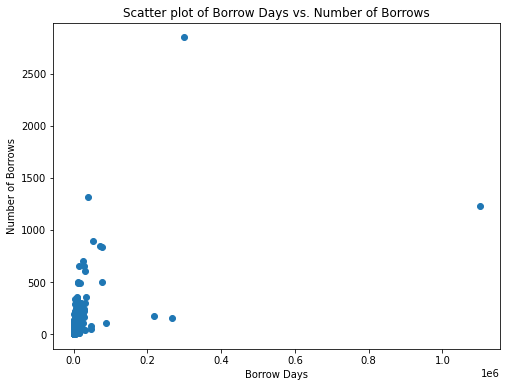

In [44]:
plt.figure(figsize=(8,6))
plt.scatter(df_new.borrow_days, df_new.borrow_numbers)
plt.xlabel('Borrow Days')
plt.ylabel('Number of Borrows')
plt.title('Scatter plot of Borrow Days vs. Number of Borrows')
plt.show()

In [45]:
# Import the sklearn function
from sklearn.preprocessing import StandardScaler

columns = df_new.columns
data_to_standardize = df_new[columns]
scaler = StandardScaler().fit(data_to_standardize)

# Standardize the columns.
standardized_data = df_new.copy()
standardized_columns = scaler.transform(data_to_standardize)
standardized_data[columns] = standardized_columns

standardized_data

,borrow_days,borrow_numbers,score
trans_tittle_code_id,,,
10019,-0.037454,-0.116724,-0.016480
100191,-0.037454,-0.116724,-0.016480
100453,-0.037454,-0.116724,-0.016480
100493,-0.037454,-0.116724,-0.016480
100832,-0.037454,-0.116724,-0.016480
...,...,...,...
130434,7.714225,2.401737,0.605037
631105,19.260968,4.008756,2.508841
18457,23.542452,3.672961,2.819398


In [46]:
standardized_data.describe()

,borrow_days,borrow_numbers,score
count,11587.000000,1.158700e+04,1.158700e+04
mean,0.000000,-3.924634e-17,-2.452896e-18
std,1.000043,1.000043e+00,1.000043e+00
min,-0.037454,-1.167244e-01,-1.648018e-02
25%,-0.037276,-1.167244e-01,-1.647998e-02
50%,-0.036124,-1.167244e-01,-1.647904e-02
75%,-0.033109,-9.273907e-02,-1.647481e-02
max,97.578136,6.814558e+01,9.065376e+01


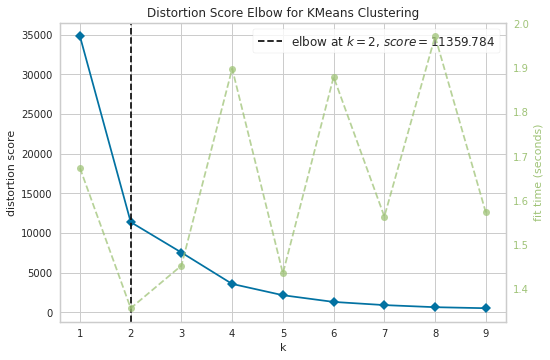

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [47]:
from yellowbrick.cluster import KElbowVisualizer

km = KMeans(init='k-means++', random_state=540)
visualizer = KElbowVisualizer(km, k=(1,10))
 
visualizer.fit(standardized_data)
visualizer.show()

In [48]:
# Train a Kmeans instance
n_clusters = visualizer.elbow_value_

kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=540)
kmeans.fit(standardized_data)
clusters = kmeans.predict(standardized_data)
df_new['cluster'] = clusters


df_new = df_new.astype({col: 'int32' for col in df_new.select_dtypes('int64').columns})
df_new = df_new.astype({col: 'int32' for col in df_new.select_dtypes('float64').columns})
df_new = df_new.astype({col: 'int32' for col in df_new.select_dtypes('bool').columns})

df_new

,borrow_days,borrow_numbers,score,cluster
trans_tittle_code_id,,,,
10019,1,1,1,0
100191,1,1,1,0
100453,1,1,1,0
100493,1,1,1,0
100832,1,1,1,0
...,...,...,...,...
130434,87427,106,9267262,0
631105,217655,173,37654315,0
18457,265943,159,42284937,0


In [49]:
from sklearn.decomposition import PCA

from sklearn.neural_network import MLPClassifier

pca = PCA(n_components=2)

reduced_X = pd.DataFrame(pca.fit_transform(standardized_data), columns=["PC1", "PC2"])
reduced_X

,PC1,PC2
0,-0.091323,0.079155
1,-0.091323,0.079155
2,-0.091323,0.079155
3,-0.091323,0.079155
4,-0.091323,0.079155
...,...,...
11582,6.218775,1.510236
11583,15.150763,5.738663
11584,17.749396,8.000753
11585,85.786893,-31.541687


In [50]:
reduced_X['cluster'] = clusters
reduced_X

,PC1,PC2,cluster
0,-0.091323,0.079155,0
1,-0.091323,0.079155,0
2,-0.091323,0.079155,0
3,-0.091323,0.079155,0
4,-0.091323,0.079155,0
...,...,...,...
11582,6.218775,1.510236,0
11583,15.150763,5.738663,0
11584,17.749396,8.000753,0
11585,85.786893,-31.541687,1


/opt/app/.venv/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


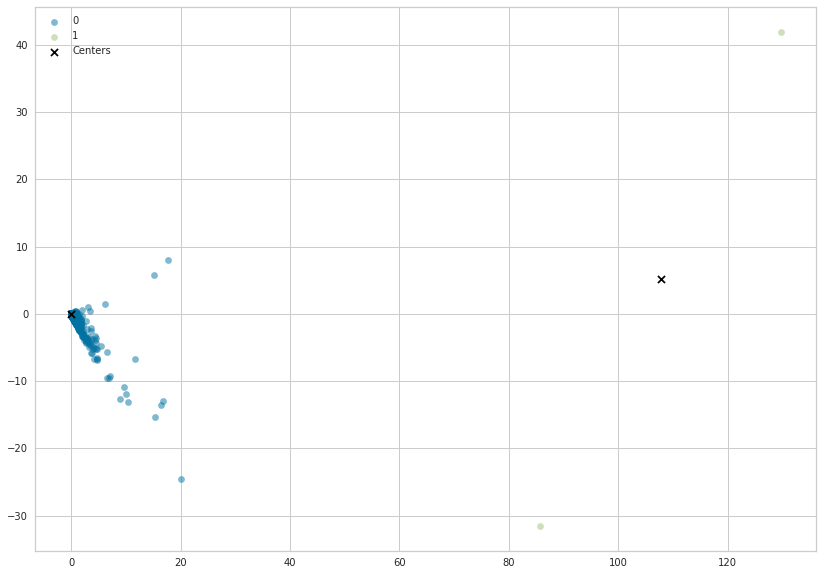

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 10))

reduced_centers = pca.transform(kmeans.cluster_centers_)

for cluster in range(0, n_clusters):
    plt.scatter(
        reduced_X[reduced_X['cluster'] == cluster].loc[:, 'PC1'],
        reduced_X[reduced_X['cluster'] == cluster].loc[:, 'PC2'], 
        label=cluster, alpha=0.5, s=40
    )

plt.scatter(reduced_centers[:, 0], reduced_centers[:, 1], marker='x', label='Centers', c="black", s=50)
plt.legend()
plt.show()

In [52]:
number_clusters = df_new['cluster'].value_counts()

In [53]:
response = []

for i in range(0, n_clusters):
    response.append(df_new[df_new['cluster'] == i].sort_values('score', ascending=False).head(15))
    
print(response)

[                      borrow_days  borrow_numbers     score  cluster
trans_tittle_code_id                                                
686887                      76814             837  64293318        0
430970                      71104             847  60225088        0
548619                      39218            1317  51650106        0
559086                      51763             889  46017307        0
18457                      265943             159  42284937        0
115561                      75508             504  38056032        0
631105                     217655             173  37654315        0
604957                      31119             606  18858114        0
584102                      27818             655  18220790        0
358787                      24280             701  17020280        0
544819                      34433             359  12361447        0
130434                      87427             106   9267262        0
463593                      13978

In [54]:
df_new

,borrow_days,borrow_numbers,score,cluster
trans_tittle_code_id,,,,
10019,1,1,1,0
100191,1,1,1,0
100453,1,1,1,0
100493,1,1,1,0
100832,1,1,1,0
...,...,...,...,...
130434,87427,106,9267262,0
631105,217655,173,37654315,0
18457,265943,159,42284937,0


In [55]:
df_new.info()


<class 'pandas.core.frame.DataFrame'>
Index: 11587 entries, 10019 to 595971
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   borrow_days     11587 non-null  int32
 1   borrow_numbers  11587 non-null  int32
 2   score           11587 non-null  int32
 3   cluster         11587 non-null  int32
dtypes: int32(4)
memory usage: 529.6+ KB


In [58]:
df_final = pd.merge(
    df_new, df_titles, on=['trans_tittle_code_id']
).drop_duplicates()
df_final

,borrow_days,borrow_numbers,score,cluster,title_name
trans_tittle_code_id,,,,,
10019,1,1,1,0,Contaminacion atmosferica
100191,1,1,1,0,Fragmentos
100453,1,1,1,0,La guerra que viene
100493,1,1,1,0,Introductory circuit analysis
100832,1,1,1,0,Las aeronaves y sus materiales
...,...,...,...,...,...
130434,87427,106,9267262,0,Introducción al análisis de circuitos
631105,217655,173,37654315,0,Essential grammar in use
18457,265943,159,42284937,0,Accent inventory to accompany Manual of americ...
